<a href="https://colab.research.google.com/github/nikishkaaa/ML-Course/blob/main/%22HW_NLP_Classification_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [2]:
!pip install opendatasets --upgrade --quiet

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import opendatasets as od
import os
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [37]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
dataset_url = "https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: darianikishkina
Your Kaggle Key: ··········


100%|██████████| 1.39M/1.39M [00:00<00:00, 116MB/s]


Extracting archive ./tweet-sentiment-extraction/tweet-sentiment-extraction.zip to ./tweet-sentiment-extraction


In [7]:
data_dir = './tweet-sentiment-extraction'
os.listdir(data_dir)

['test.csv', 'train.csv', 'sample_submission.csv']

In [8]:
df = pd.read_csv("./tweet-sentiment-extraction/train.csv")
df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [11]:
df.shape

(27481, 4)

In [14]:
 df.isna().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [16]:
df = df[df['text'].notna()]

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [31]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


<Axes: xlabel='sentiment', ylabel='count'>

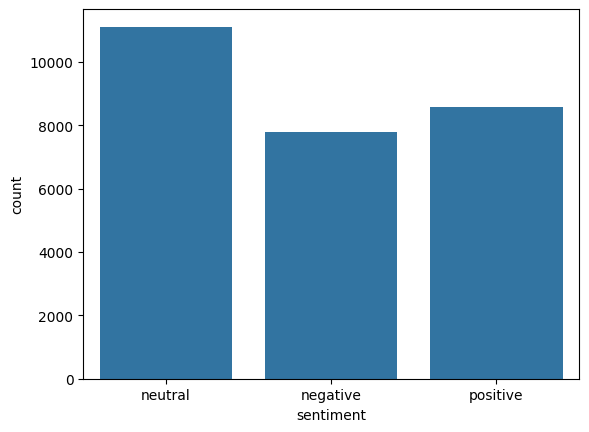

In [18]:
sns.countplot(x ='sentiment', data = df)

<Axes: >

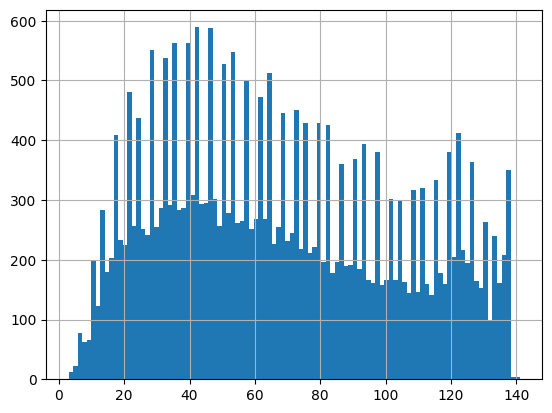

In [30]:
df['post_len'] = df['text'].apply(len)

df.post_len.hist(bins=100)

Висновок:
1. Класи:  розподіл класів нерівномірний, neutral - найбільше. Negative i positive - майже однаково.
2. Довжина постів: розподіл нерівномірний. Основна частина постів від 20 до 80 символів

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




#### Removing chars

In [87]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [90]:
df['text'] = df['text'].apply(lambda x:clean_text(x))
df['selected_text'] = df['selected_text'].apply(lambda x:clean_text(x))

#### Stop words removing

In [51]:
english_stopwords = stopwords.words('english')

In [59]:
def remove_stop_words(text):
  return [word for word in tokens if word.lower() not in english_stopwords]

#### Tokenizer + Stemper

In [52]:
stemmer = SnowballStemmer(language='english')
def tokenize(text):
    return [stemmer.stem(word) for word in word_tokenize(text)]

#### CountVectorizer

In [66]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=english_stopwords)

In [67]:
vectorizer.fit(df.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x7f3ed8329750>)

In [69]:
num_tokens = len(vectorizer.vocabulary_)
print("Tokens:", num_tokens)

Tokens: 23100


#### Adding new stop words based on warning

In [62]:
new_stop_words =  ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv']
combined_stop_words = english_stopwords + new_stop_words

In [79]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=combined_stop_words,
                             max_df = 15000,
                             min_df= 2)

In [80]:
vectorizer.fit(df.text)

CountVectorizer(max_df=15000, min_df=2,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x7f3ed8329750>)

In [81]:
num_tokens = len(vectorizer.vocabulary_)
print("Tokens:", num_tokens)

Tokens: 8252


#### Пошук оптимального значення для max_features

In [83]:
from sklearn.model_selection import KFold

max_features_list = [100, 500, 1000, 2000, None]

cv = KFold(n_splits=5)
results = {}

for max_features in max_features_list:
    feature_counts = []
    for train_index, test_index in cv.split(df.text):
        X_train, X_test = np.array(df.text)[train_index], np.array(df.text)[test_index]

        vectorizer = CountVectorizer(lowercase=True,
                                      tokenizer=tokenize,
                                      stop_words=combined_stop_words,
                                       max_df = 15000,
                                      min_df= 2,
                                      max_features=max_features)
        vectorizer.fit(X_train)

        num_tokens = len(vectorizer.vocabulary_)
        feature_counts.append(num_tokens)

    results[max_features] = np.mean(feature_counts)

for max_features, avg_tokens in results.items():
    print(f"max_features: {max_features}, AVG count of tokens: {avg_tokens}")


max_features: 100, AVG count of tokens: 100.0
max_features: 500, AVG count of tokens: 500.0
max_features: 1000, AVG count of tokens: 1000.0
max_features: 2000, AVG count of tokens: 2000.0
max_features: None, AVG count of tokens: 7162.4


Висновок: найоптимальніший параметр для max_features = 1000.

In [85]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=combined_stop_words,
                             max_df = 15000,
                             min_df= 2,
                             max_features=1000)
vectorizer.fit(df.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_df=15000, max_features=1000, min_df=2,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x7f3ed8329750>)

In [91]:
inputs = vectorizer.transform(df.text)

In [92]:
inputs.shape

(27480, 1000)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [95]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(inputs, df.sentiment, random_state=42, test_size=0.3, stratify=df.sentiment)

#### Logistic regression

In [97]:
log_reg =  LogisticRegression(solver = 'sag', max_iter=1000)
log_reg.fit(X_train_bow, y_train)
log_preds = log_reg.predict(X_test_bow)

In [98]:
log_preds

array(['negative', 'negative', 'neutral', ..., 'positive', 'positive',
       'positive'], dtype=object)

In [103]:
proba = log_reg.predict_proba(X_train_bow)
proba

array([[0.10335362, 0.80258191, 0.09406447],
       [0.17947626, 0.57078638, 0.24973736],
       [0.96897316, 0.021523  , 0.00950384],
       ...,
       [0.21586844, 0.68175257, 0.10237899],
       [0.10733439, 0.24290639, 0.64975922],
       [0.29279401, 0.56005944, 0.14714655]])

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model